In [1]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafeMeanCov
using Revise
using LAR.Node
using LAR.Data
using ProgressMeter
using LinearAlgebra
using Plots

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1260
┌ Info: Precompiling LAR [c3bc7fac-5998-4d64-8961-b7df36e0e4ce]
└ @ Base loading.jl:1260
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [2]:
ARorder = 5
n_samples = 100
tau = 1.0
coefs, reals = generateAR(n_samples, ARorder)
obs = [x[1] + sqrt(tau)*randn() for x in reals]
reals = [x[1] for x in reals]

100-element Array{Float64,1}:
 -0.5673486241548332
 -2.070645390603126
  1.4237301327604865
 -0.5760241705277225
  1.9252436975474496
  0.9534241124878365
 -3.43400359596052
  3.5076918384786606
 -1.947672929890167
  1.0465190002497404
  1.4448275320669897
 -4.0573206835310245
  4.108703650780916
  ⋮
  3.6882102723881234
 -0.2872741601613056
 -1.240382688857517
  1.3699734667494847
 -3.141153142599846
  1.2987963832226774
 -0.37696557726318625
  0.912210933209067
  3.2069913216129824
 -3.5434361648216663
 -0.029696662702605625
 -0.39863144682370844

In [3]:
fg = FactorGraph()

# State prior
@RV x_0 ~ GaussianMeanVariance(placeholder(:m_x_0, dims=(ARorder, )),
                               placeholder(:v_x_0, dims=(ARorder, ARorder)))

@RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(ARorder, )),
                             placeholder(:v_θ, dims=(ARorder, ARorder)))

@RV γ ~ Gamma(placeholder(:a), placeholder(:b))

# Transition and observation model
x = Vector{Variable}(undef, n_samples)
y = Vector{Variable}(undef, n_samples)

c = zeros(ARorder); c[1] = 1.0

x_i_min = x_0
for i in 1:n_samples
    global x_i_min
    @RV x[i] ~ Autoregressive(θ, x_i_min, γ)

    @RV y[i] ~ GaussianMeanPrecision(dot(c, x[i]), inv(tau))

    # Data placeholder
    placeholder(y[i], :y, index=i)

    # Reset state for next step
    x_i_min = x[i]
end

In [4]:
q = PosteriorFactorization(x_0, x, γ, θ, ids=[:X0 :X :Γ :Θ])
algo = variationalAlgorithm(q, free_energy=true)
src_code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(src_code))

freeEnergy (generic function with 1 method)

In [5]:
# Initial posterior factors
marginals = Dict{Symbol, ProbabilityDistribution}()
marginals[:θ] = vague(GaussianMeanVariance, ARorder)
marginals[:γ] = ProbabilityDistribution(Gamma, a=1.0, b=1.0)
for i in 0:n_samples
    marginals[:x_*i] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(ARorder), v=diagm(ones(ARorder)))
end

In [8]:
data = Dict(:y => obs, :m_x_0 => zeros(ARorder), :v_x_0 => diagm(ones(ARorder)),
                :m_θ => zeros(ARorder), :v_θ => diagm(ones(ARorder)),
                :a => 1.0, :b => 1.0, :tau=>tau)

n_its = 20
fe = Vector{Float64}(undef, n_its)
# Run algorithm
@showprogress for i in 1:n_its
    stepX0!(data, marginals)
    stepX!(data, marginals)
    stepΘ!(data, marginals)
    stepΓ!(data, marginals)
    fe[i] = freeEnergy(data, marginals)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


In [9]:
m_x = [unsafeMean(marginals[Symbol("x_$(i+1)_x_$(i)")])[1] for i in 2:length(obs)-1]
v_x = [unsafeCov(marginals[Symbol("x_$(i+1)_x_$(i)")])[1] for i in 2:length(obs)-1]
insert!(m_x, 1, unsafeMean(marginals[:x_1])[1])
insert!(m_x, 1, unsafeMean(marginals[:x_0])[1])
insert!(v_x, 1, unsafeCov(marginals[:x_1])[1])
insert!(v_x, 1, unsafeCov(marginals[:x_0])[1])

100-element Array{Float64,1}:
 9.999999999989583e-13
 0.447112651915192
 0.4512334687045071
 0.45127038239811884
 0.4529587578768761
 0.4821919570584652
 0.4824437328538921
 0.4829184757082831
 0.4829188731047528
 0.4833156186932201
 0.48531073904607674
 0.4853257177239486
 0.48539091333706236
 ⋮
 0.48631185923351455
 0.4863649877608704
 0.4905004447977309
 0.4924623963173447
 0.492572678996477
 0.49325780393179586
 0.49422988644491456
 0.5529683437200809
 0.5683329498933963
 0.5697239458120037
 0.5732602302521582
 0.585992825358758

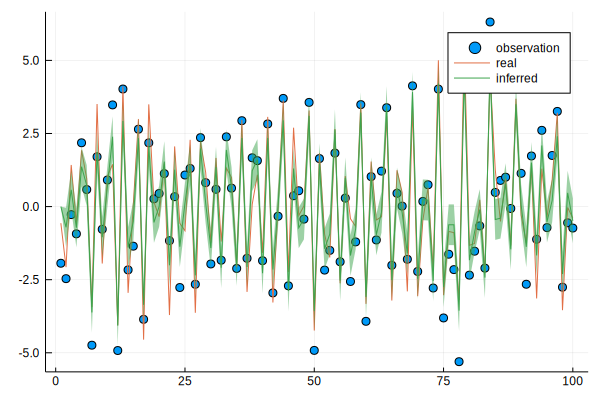

In [10]:
scatter(obs, label="observation")
plot!(reals, label="real")
plot!(m_x, ribbon=sqrt.(v_x), label="inferred")

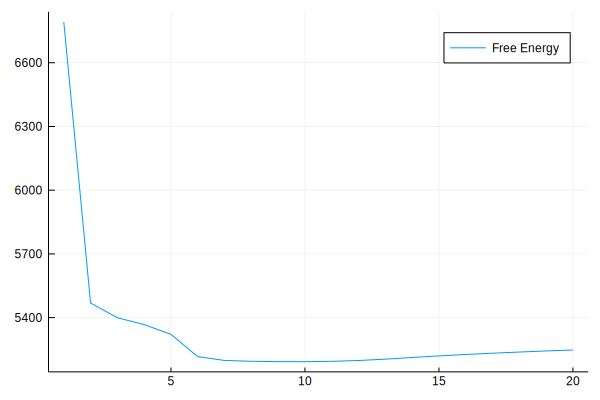

In [11]:
plot(fe, label="Free Energy")